In [1]:
from __future__ import division
import numpy as np
import random
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt

def small_f(S_a, I_x):

    # return the sim of the image in S_a with highest sim with I_x
    max_sim = 0
    max_sim_idx = 0
#     print(I_sa.shape)
#     print(I_x.shape)
    for I_sa in S_a:
        sim = cos_sim(I_sa, I_x)
#         print(sim.shape)
        if sim > max_sim:
            max_sim = sim

    return max_sim


def big_f(S_a, S_u):
    # Sum small_f for all images in S_u f_small(S_a, I_from_S_u)
    current_sum = 0
    for I_su in S_u:
        current_sum += small_f(S_a, I_su)

    return current_sum


def cos_sim(I_i, I_j):
    return np.dot(I_i, I_j.T) / I_i.shape[0] ** 2


def max_rep(S_u, S_c, Sc_idx):
    S_a_idx = []
    S_a = []

    while len(S_a) < small_k:
        current_best = 0
        current_best_idx = None
        for i, img_and_idx in enumerate(zip(S_c, Sc_idx)):
            S_a.append(img_and_idx[0])
            tmp_score = big_f(S_a, S_u)
            if tmp_score > current_best:
                current_best = tmp_score
                current_best_idx = i

            S_a.pop()

        S_a.append(S_c[current_best_idx])
        S_a_idx.append(Sc_idx[current_best_idx])
        S_c.pop(current_best_idx)
        Sc_idx.pop(current_best_idx)

    return S_a_idx

# With our data ready, we will extract random patches (in the same place for each of the three data points per subject)

def extract_random_patches(image_list, conf_list, feat_list, seg_list,
                                 example_size=[1, 64, 64],
                                 n_examples=16):
    """Randomly extract training examples from image (and a corresponding label).
        Returns an image example array and the corresponding label array.

    Args:
        image_list (np.ndarray or list or tuple): image(s) to extract random
            patches from
        example_size (list or tuple): shape of the patches to extract
        n_examples (int): number of patches to extract in total

    Returns:
        np.ndarray, np.ndarray: class-balanced patches extracted from full
        images with the shape [batch, example_size..., image_channels]
    """

    assert n_examples > 0

    was_singular = False
    if isinstance(image_list, np.ndarray):
        image_list = [image_list]
        conf_list = [conf_list]
        feat_list = [feat_list]
        seg_list = [seg_list]
        was_singular = True

    assert all([i_s >= e_s for i_s, e_s in zip(image_list[0].shape, example_size)]), \
        'Image must be bigger than example shape'
    assert (image_list[0].ndim - 1 == len(example_size)
            or image_list[0].ndim == len(example_size)), \
        'Example size doesnt fit image size'

    for i in image_list:
        if len(image_list) > 1:
            assert (i.ndim - 1 == image_list[0].ndim
                    or i.ndim == image_list[0].ndim
                    or i.ndim + 1 == image_list[0].ndim), \
                'Example size doesnt fit image size'

            assert all([i0_s == i_s for i0_s, i_s in zip(image_list[0].shape, i.shape)]), \
                'Image shapes must match'

    rank = len(example_size)

    # Extract random examples from image and label
    valid_loc_range = [image_list[0].shape[i] - example_size[i] for i in range(rank)]

    rnd_loc = [np.random.randint(valid_loc_range[dim], size=n_examples)
               if valid_loc_range[dim] > 0
               else np.zeros(n_examples, dtype=int) for dim in range(rank)]

    examples = [[]] * len(image_list)
    examples_f = [[]] * len(feat_list)
    examples_c = [[]] * len(conf_list)
    examples_s = [[]] * len(seg_list)
    for i in range(n_examples):
        slicer = [slice(rnd_loc[dim][i], rnd_loc[dim][i] + example_size[dim])
                  for dim in range(rank)]

        for j in range(len(image_list)):
            ex_image = image_list[j][slicer][np.newaxis]
            ex_conf = conf_list[j][slicer][np.newaxis]
            ex_feat = feat_list[j][slicer][np.newaxis]
            ex_seg = seg_list[j][slicer][np.newaxis]
            # Concatenate and return the examples
            examples[j] = np.concatenate((examples[j], ex_image), axis=0) \
                if (len(examples[j]) != 0) else ex_image
            examples_f[j] = np.concatenate((examples_f[j], ex_feat), axis=0) \
                if (len(examples_f[j]) != 0) else ex_feat
            examples_c[j] = np.concatenate((examples_c[j], ex_conf), axis=0) \
                if (len(examples_c[j]) != 0) else ex_conf
            examples_s[j] = np.concatenate((examples_s[j], ex_seg), axis=0) \
                if (len(examples_s[j]) != 0) else ex_seg

    if was_singular:
        return [examples[0],examples_c[0], examples_f[0], examples_s[0]]
    return [examples, examples_c, examples_f, examples_s]

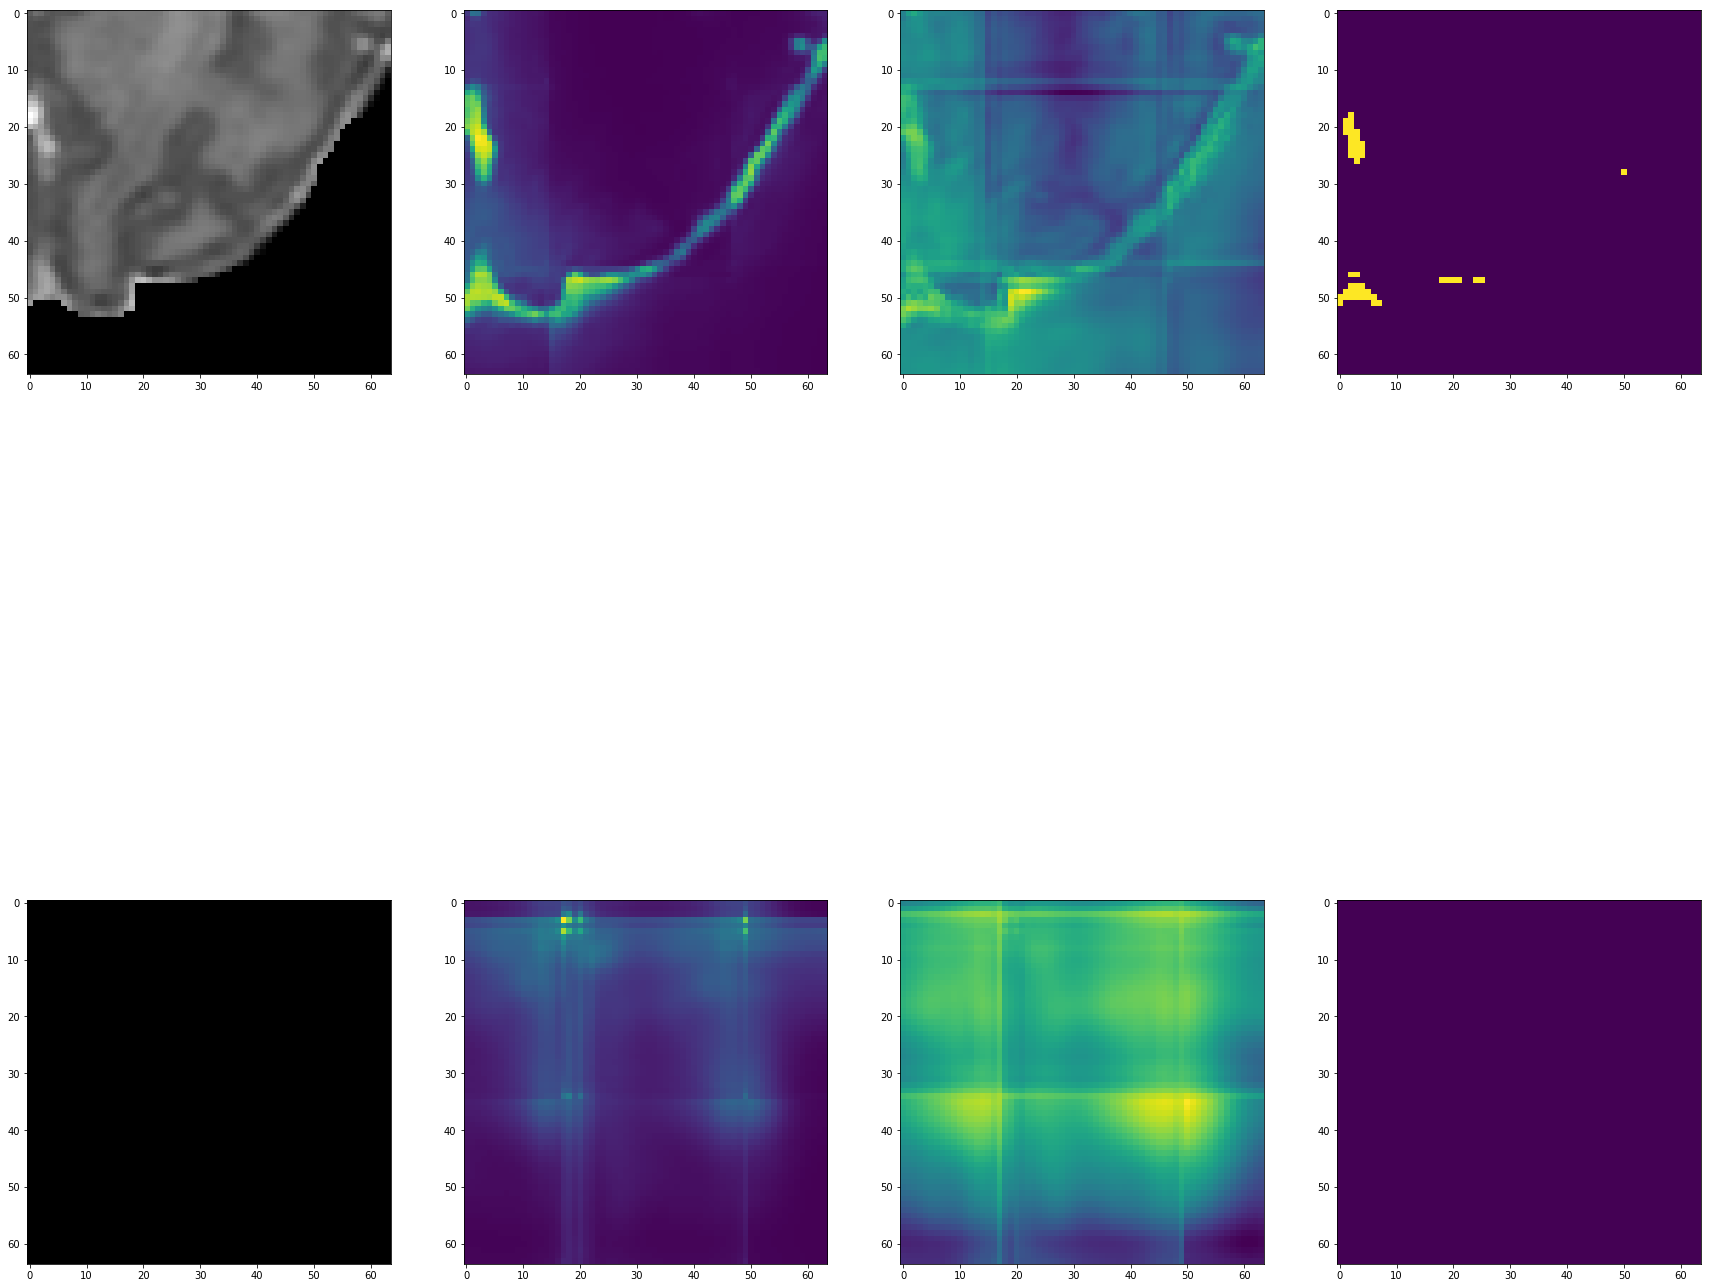

In [2]:
# Load our example data into memory
num_images = 5
data_dir = "C:\\Users\\sb17\\MResProject\\DLTK\\contributions\\applications\\AL_framework\\datasets\\ALout\\"

file_names = pd.read_csv(
                data_dir + "im_refs.csv",
                dtype=object,
                keep_default_na=False,
                na_values=[]).as_matrix()



images = []
confidences = []
features = []
segs = []

for im in file_names:
    im_id = im[0]
#     print(im_id)
    im_name = im[2] + "T2w_restore_brain.nii.gz"
    image = sitk.GetArrayFromImage(sitk.ReadImage(data_dir+im_name))
    conf = sitk.GetArrayFromImage(sitk.ReadImage(data_dir+str(im_id)+"_conf.nii.gz"))
    feat = sitk.GetArrayFromImage(sitk.ReadImage(data_dir+str(im_id)+"_feat.nii.gz"))
    seg = sitk.GetArrayFromImage(sitk.ReadImage(data_dir+str(im_id)+"_seg.nii.gz"))
    patches = extract_random_patches(image, conf, feat, seg, n_examples=100)
    images = np.concatenate((images, patches[0]), axis=0) \
                if (len(images) != 0) else patches[0]
    confidences = np.concatenate((confidences, patches[1]), axis=0) \
                if (len(confidences) != 0) else patches[1]
    features = np.concatenate((features, patches[2]), axis=0) \
                if (len(features) != 0) else patches[2]
    segs = np.concatenate((segs, patches[3]), axis=0) \
                if (len(segs) != 0) else patches[3]



fig, axes = plt.subplots(2, 4, figsize=(30,30))
for i in range(0, 2):
    axes[i][0].imshow(images[i][0], cmap='gray')
    axes[i][1].imshow(confidences[i][0,:,:,1])
    axes[i][2].imshow(features[i][0,:,:,1])
    axes[i][3].imshow(segs[i][0])

Without Replacement:  True


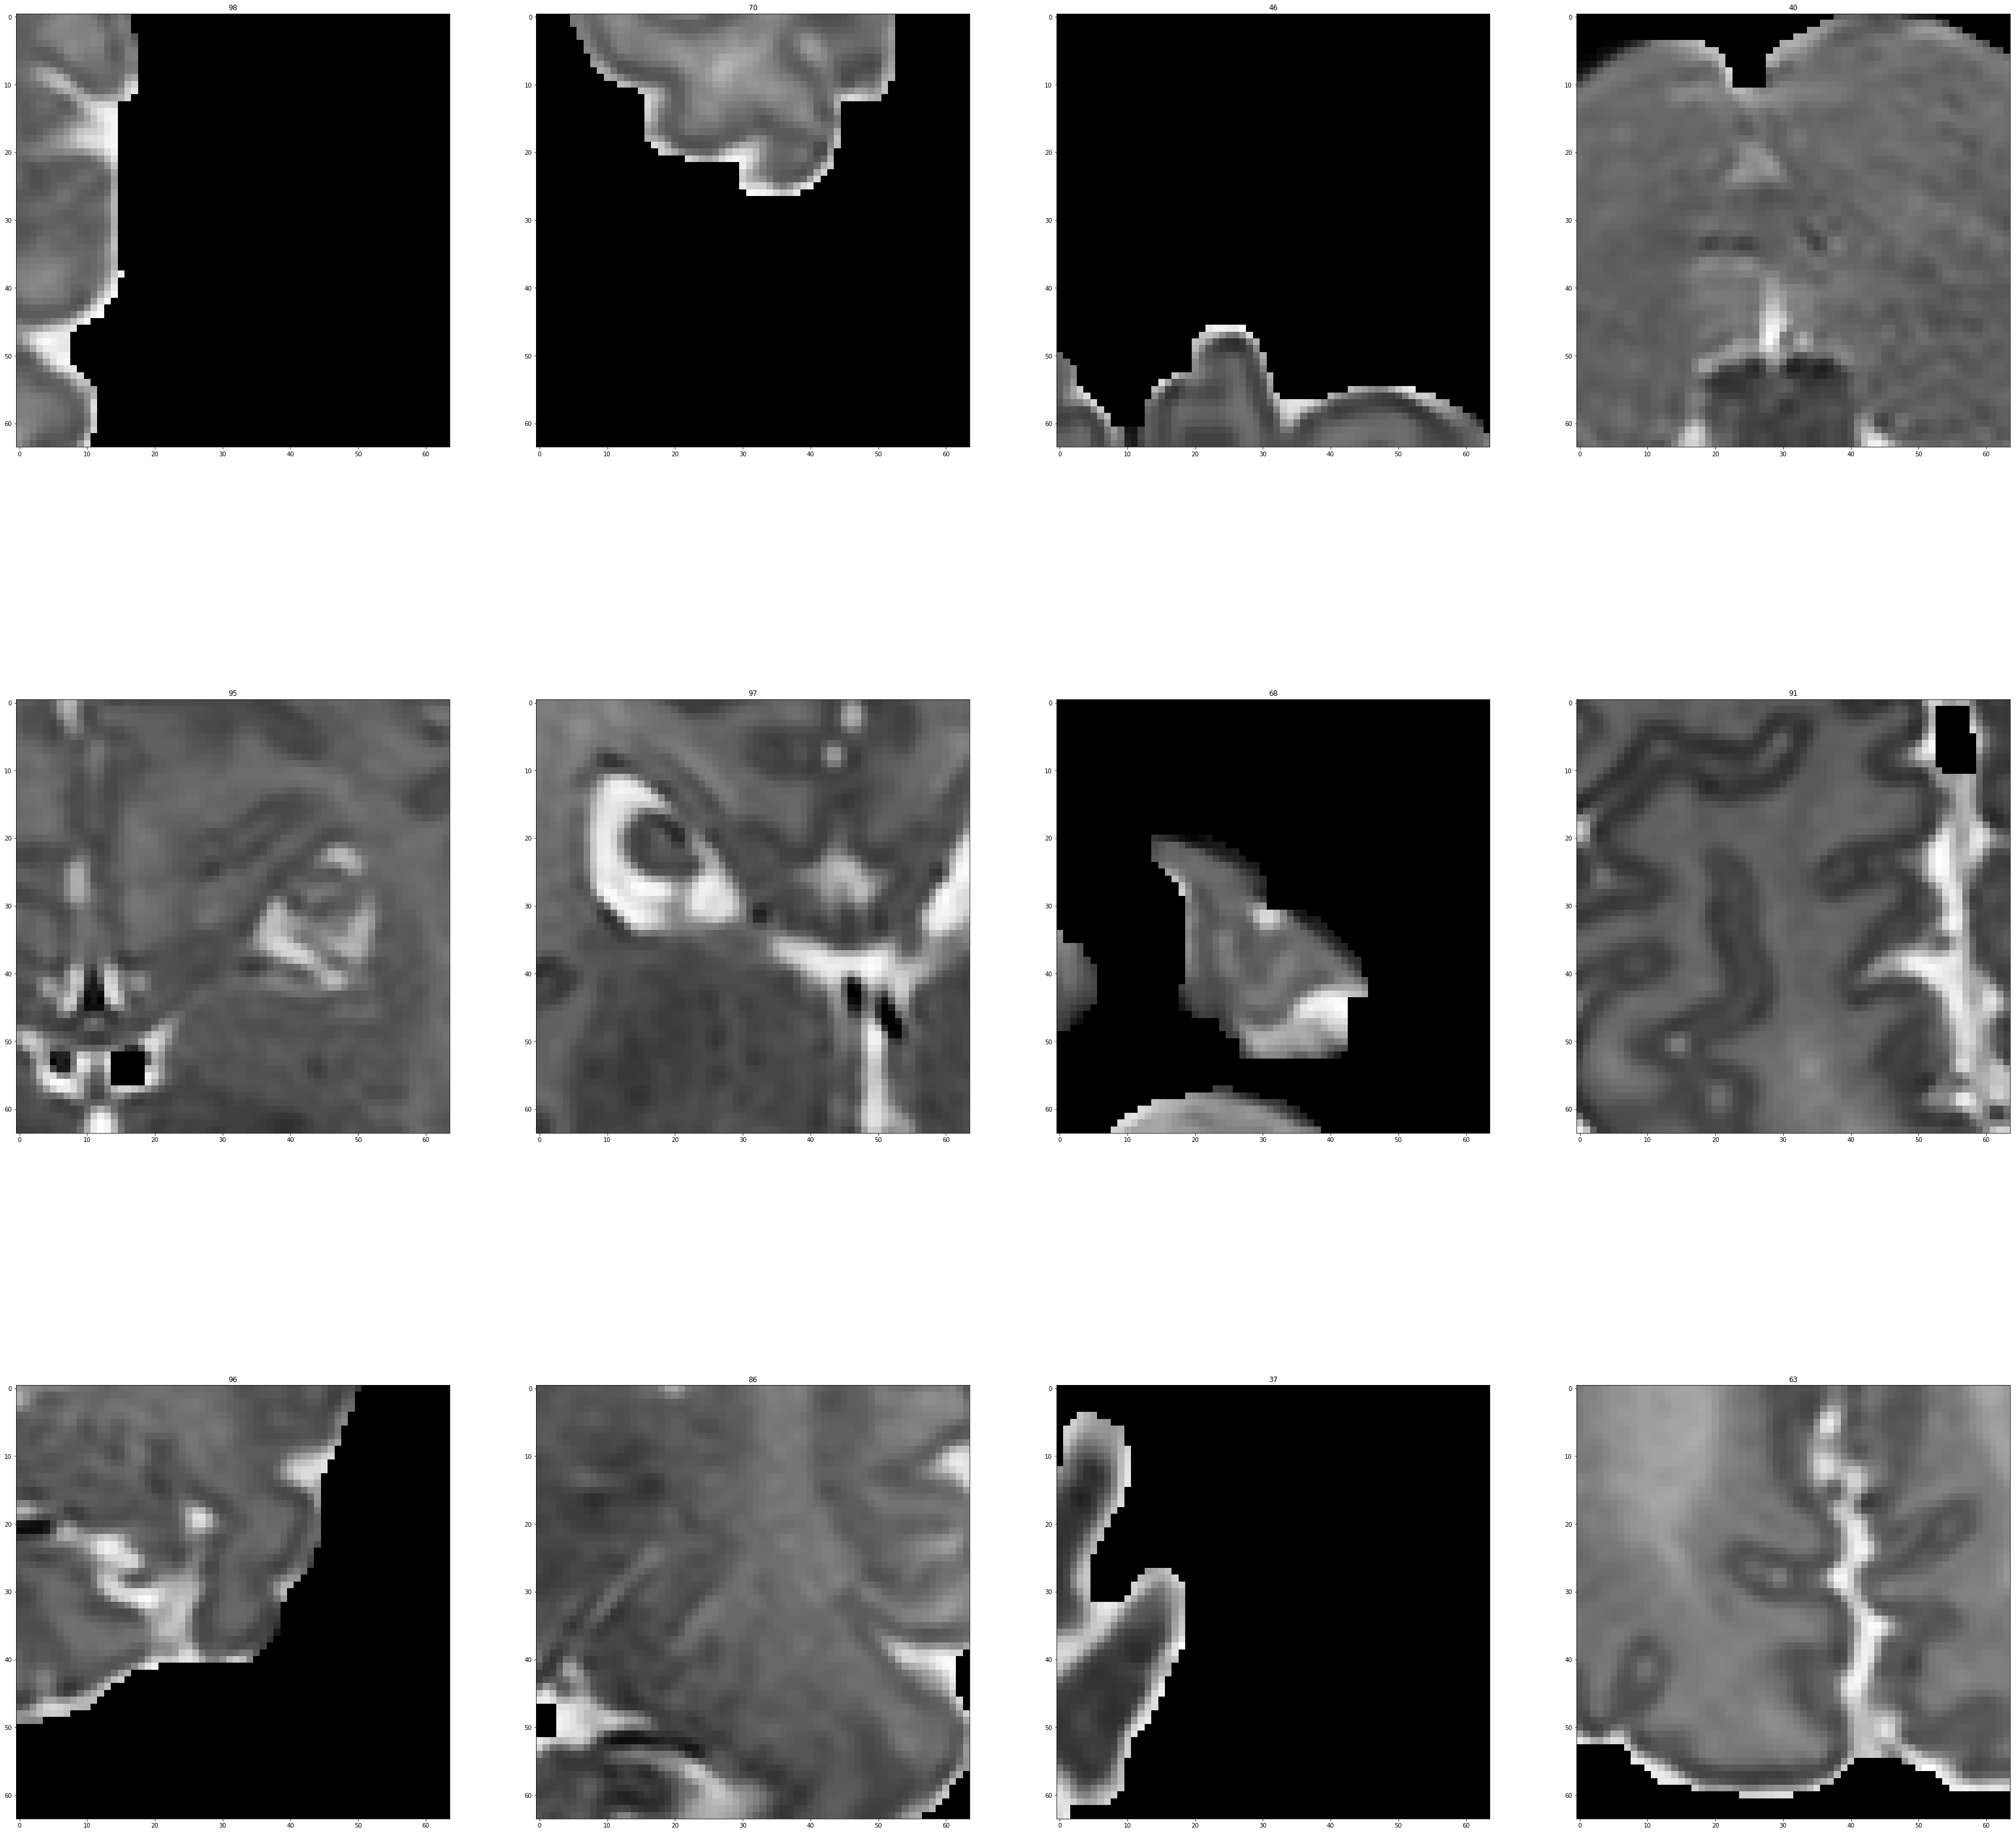

In [5]:
# We now have our matching patches (raw image, class confidences, feature maps?)

# For each patch we flatten the confidence scores into a single value for that patch (higher = more confident)
# This is done by summing the higher confidence score for each pixel in the patch
confidence_vals = np.max(confidences, axis=-1)
confidence_vals = np.sum(confidence_vals, axis=-1)
confidence_vals = np.sum(confidence_vals, axis=-1)
confidence_vals = confidence_vals.reshape(500)

sorted_indices = np.argsort(confidence_vals, axis=-1)
top_conf_indices = sorted_indices[:100] #swap sign for alternate ends of list

top_conf_images = [images[i] for i in top_conf_indices]
top_conf_feat = [features[i] for i in top_conf_indices]
top_conf_segs = [segs[i] for i in top_conf_indices]

# We have our most uncertain images, now use the features to select the most representative
# Using Suggestive Annotation algorithm 

big_k = 8 # 8
small_k = 4 # 4
num_iterations = 3
S_u = list(top_conf_feat)
S_u = [np.array(x).flatten() for x in S_u]
S_u_idx = range(len(S_u))
S_a = []  # These are actual annotated

for i in range(num_iterations):
#     random_Sc_idx = random.sample(range(0,len(S_u_idx)), big_k)    # original code introduces duplicates
    random_Sc_idx = random.sample(S_u_idx, big_k)
    S_c = np.array([np.array(x).flatten() for x in top_conf_feat])
    S_c = S_c[random_Sc_idx, :]
    S_c = list(S_c)

    S_a_indices = max_rep(S_u, S_c, random_Sc_idx)
    S_a.extend(S_a_indices)
    # removes indices for next run
    S_u_idx = [x for x in range(len(S_u)) if x not in S_a]

print("Without Replacement: ", str(num_iterations*small_k == len(np.unique(S_a))))  

fig, axes = plt.subplots(num_iterations,small_k,figsize=(60,60))
c = 0
for i in range(0, len(axes)):
    for j in range(0, len(axes[0])):
        axes[i, j].imshow(top_conf_images[S_a[c]][0], cmap='gray')
        axes[i, j].set_title(str(S_a[c]))
        c = c+1
    

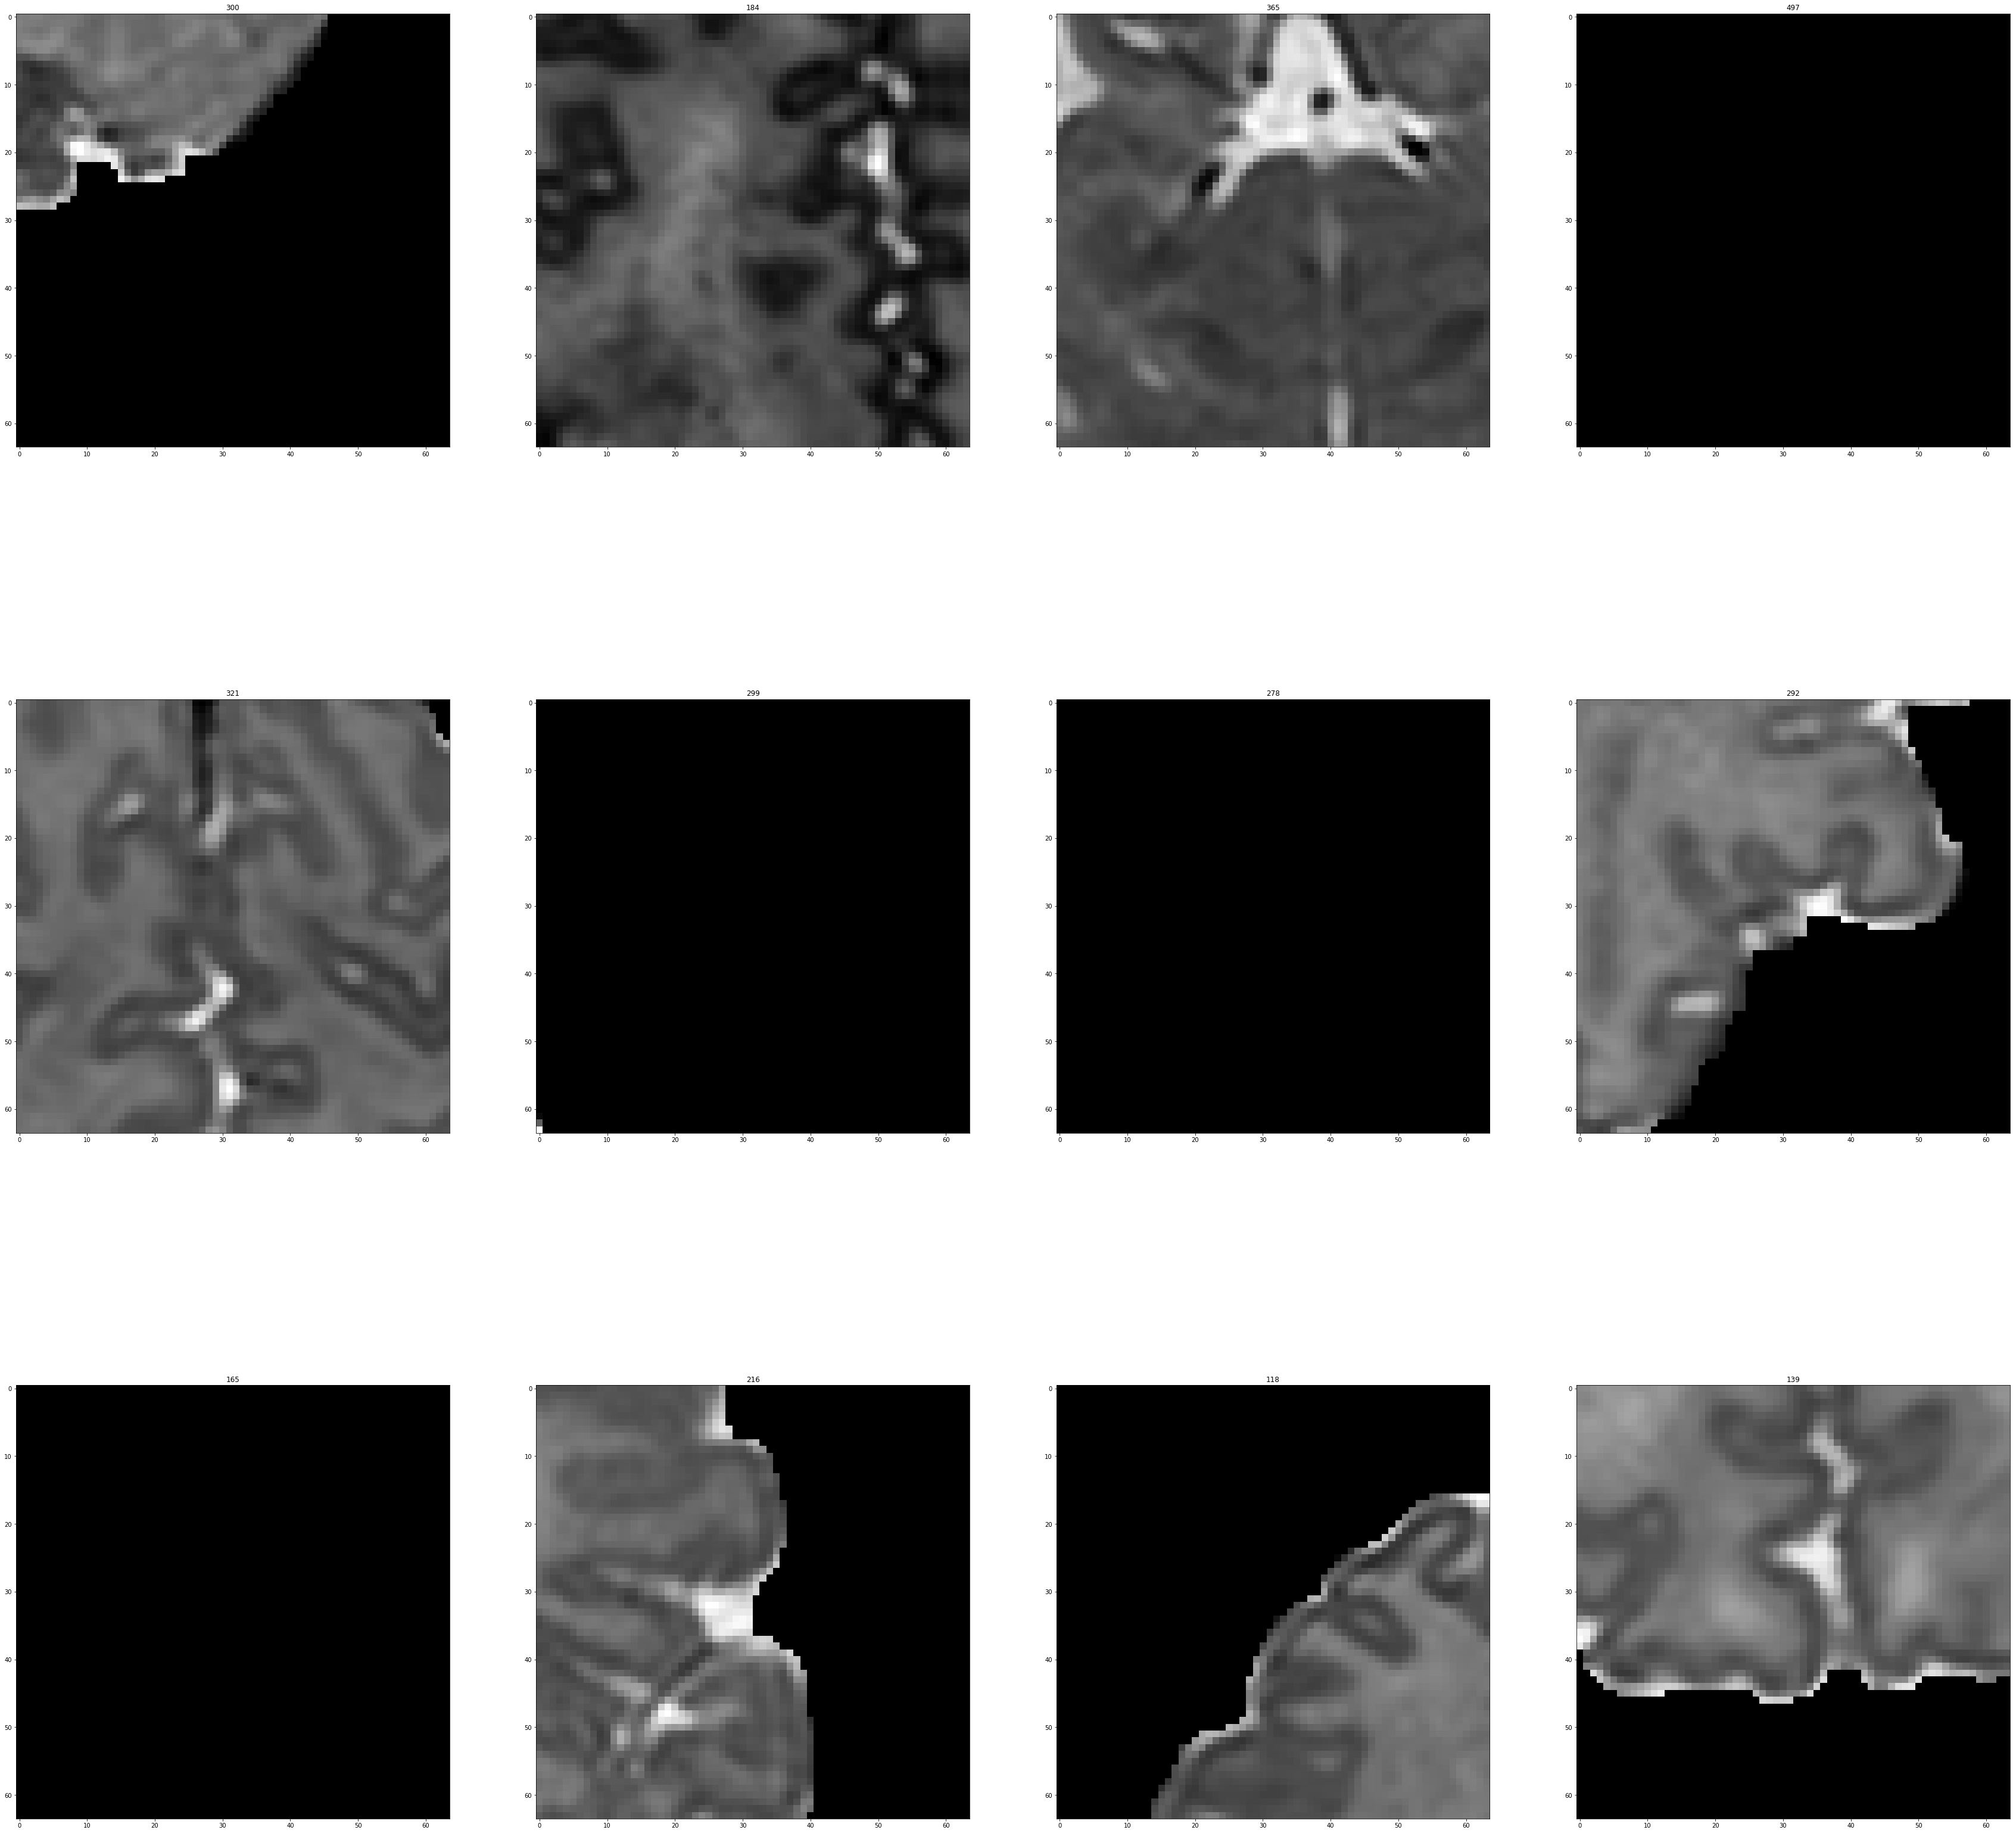

In [4]:
# Random selection
num_iterations = 3
small_k = 4
random_Sc_idx = random.sample(range(0, len(images)), 40)

fig, axes = plt.subplots(num_iterations, small_k,figsize=(60,60))
c = 0
for i in range(0, len(axes)):
    for j in range(0, len(axes[0])):
        axes[i, j].imshow(images[random_Sc_idx[c]][0], cmap='gray')
        axes[i, j].set_title(str(random_Sc_idx[c]))
        c = c+1

In [2]:
# # Confidence ranking, Random selection
# random_Sc_idx = random.sample(range(0, len(top_conf_indices)), 40)

# fig, axes = plt.subplots(num_iterations, small_k,figsize=(60,60))
# c = 0
# for i in range(0, len(axes)):
#     for j in range(0, len(axes[0])):
#         axes[i, j].imshow(top_conf_images[random_Sc_idx[c]][0], cmap='gray')
#         axes[i, j].set_title(str(random_Sc_idx[c]))
#         c = c+1


In [6]:
print(len(S_a))
print(S_a)
print(len(top_conf_images))
# patches = [top_conf_images[S_a[c]] for c in S_a]
patches = np.array(top_conf_images)[S_a]
seg_patches = np.array(top_conf_segs)[S_a]
print(type(patches[0,0,0,0]))

12
[98, 70, 46, 40, 95, 97, 68, 91, 96, 86, 37, 63]
100
<class 'numpy.float32'>


In [7]:
# patches = [x[0] for x in patches]
# seg_patches = [x[0] for x in seg_patches]
print(np.array(seg_patches[1]).shape)

(1, 64, 64)


In [9]:
# Save the patches, associated segs, confs and feats
save_dir =  'C:\\Users\\sb17\\MResProject\\DLTK\\contributions\\applications\\AL_framework\\applications\\app0\\data\\'
for i, index in enumerate(S_a):
    patch = top_conf_images[index]
    print(patch.shape)
    seg = top_conf_segs[index]
    sitk.WriteImage(sitk.GetImageFromArray(patch), save_dir+'raw\\'+str(i)+'_patch.nii.gz')
    sitk.WriteImage(sitk.GetImageFromArray(seg), save_dir+'seg\\'+str(i)+'_seg.nii.gz')


(1, 64, 64)
(1, 64, 64)
(1, 64, 64)
(1, 64, 64)
(1, 64, 64)
(1, 64, 64)
(1, 64, 64)
(1, 64, 64)
(1, 64, 64)
(1, 64, 64)
(1, 64, 64)
(1, 64, 64)


In [102]:
sitk.WriteImage(sitk.GetImageFromArray(patches[1]), data_dir + "patch_example.nii.gz")
sitk.WriteImage(sitk.GetImageFromArray(seg_patches[1]), data_dir + "seg_example.nii.gz")

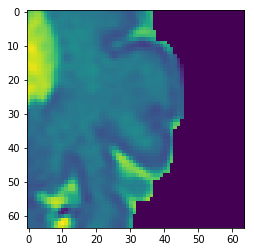

In [96]:
png = sitk.ReadImage(data_dir + "patch_example.nii.gz")
arr = sitk.GetArrayFromImage(png)
plt.imshow(arr)

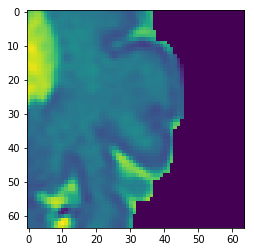

In [97]:
plt.imshow(top_conf_images[S_a[1]][0])

In [98]:
print((top_conf_images[S_a[1]][0] == arr).shape)

(64, 64)


In [99]:
print((top_conf_images[S_a[1]][0] == arr))


[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [2]:
def extract_random_example_array(image_list,
                                 example_size=[1, 64, 64],
                                 n_examples=1):
    """Randomly extract training examples from image (and a corresponding label).
        Returns an image example array and the corresponding label array.

    Args:
        image_list (np.ndarray or list or tuple): image(s) to extract random
            patches from
        example_size (list or tuple): shape of the patches to extract
        n_examples (int): number of patches to extract in total

    Returns:
        np.ndarray, np.ndarray: class-balanced patches extracted from full
        images with the shape [batch, example_size..., image_channels]
    """

    assert n_examples > 0

    was_singular = False
    if isinstance(image_list, np.ndarray):
        image_list = [image_list]
        was_singular = True

    assert all([i_s >= e_s for i_s, e_s in zip(image_list[0].shape, example_size)]), \
        'Image must be bigger than example shape'
    assert (image_list[0].ndim - 1 == len(example_size)
            or image_list[0].ndim == len(example_size)), \
        'Example size doesnt fit image size'

    for i in image_list:
        if len(image_list) > 1:
            assert (i.ndim - 1 == image_list[0].ndim
                    or i.ndim == image_list[0].ndim
                    or i.ndim + 1 == image_list[0].ndim), \
                'Example size doesnt fit image size'

            assert all([i0_s == i_s for i0_s, i_s in zip(image_list[0].shape, i.shape)]), \
                'Image shapes must match'

    rank = len(example_size)

    # Extract random examples from image and label
    valid_loc_range = [image_list[0].shape[i] - example_size[i] for i in range(rank)]

    rnd_loc = [np.random.randint(valid_loc_range[dim], size=n_examples)
               if valid_loc_range[dim] > 0
               else np.zeros(n_examples, dtype=int) for dim in range(rank)]

    examples = [[]] * len(image_list)
    for i in range(n_examples):
        slicer = [slice(rnd_loc[dim][i], rnd_loc[dim][i] + example_size[dim])
                  for dim in range(rank)]

        for j in range(len(image_list)):
            ex_image = image_list[j][slicer][np.newaxis]
            # Concatenate and return the examples
            examples[j] = np.concatenate((examples[j], ex_image), axis=0) \
                if (len(examples[j]) != 0) else ex_image

    if was_singular:
        return examples[0]
    return examples

In [13]:
def extract_more_random_patches(image_list, conf_list, feat_list, seg_list, em_seg_list,
                           example_size=[1, 64, 64],
                           n_examples=16):
    """Randomly extract training examples from image (and a corresponding label).
        Returns an image example array and the corresponding label array.

    Args:
        image_list (np.ndarray or list or tuple): image(s) to extract random
            patches from
        example_size (list or tuple): shape of the patches to extract
        n_examples (int): number of patches to extract in total

    Returns:
        np.ndarray, np.ndarray: class-balanced patches extracted from full
        images with the shape [batch, example_size..., image_channels]
    """

    assert n_examples > 0

    was_singular = False
    if isinstance(image_list, np.ndarray):
        image_list = [image_list]
        conf_list = [conf_list]
        feat_list = [feat_list]
        seg_list = [seg_list]
        em_seg_list = [em_seg_list]
        was_singular = True

    assert all([i_s >= e_s for i_s, e_s in zip(image_list[0].shape, example_size)]), \
        'Image must be bigger than example shape'
    assert (image_list[0].ndim - 1 == len(example_size)
            or image_list[0].ndim == len(example_size)), \
        'Example size doesnt fit image size'

    for i in image_list:
        if len(image_list) > 1:
            assert (i.ndim - 1 == image_list[0].ndim
                    or i.ndim == image_list[0].ndim
                    or i.ndim + 1 == image_list[0].ndim), \
                'Example size doesnt fit image size'

            assert all([i0_s == i_s for i0_s, i_s in zip(image_list[0].shape, i.shape)]), \
                'Image shapes must match'

    rank = len(example_size)

    # Extract random examples from image and label
    valid_loc_range = [image_list[0].shape[i] - example_size[i] for i in range(rank)]

    rnd_loc = [np.random.randint(valid_loc_range[dim], size=n_examples)
               if valid_loc_range[dim] > 0
               else np.zeros(n_examples, dtype=int) for dim in range(rank)]

    examples = [[]] * len(image_list)
    examples_f = [[]] * len(feat_list)
    examples_c = [[]] * len(conf_list)
    examples_s = [[]] * len(seg_list)
    examples_e = [[]] * len(em_seg_list)
    for i in range(n_examples):
        slicer = [slice(rnd_loc[dim][i], rnd_loc[dim][i] + example_size[dim])
                  for dim in range(rank)]

        for j in range(len(image_list)):
            ex_image = image_list[j][slicer][np.newaxis]
            ex_conf = conf_list[j][slicer][np.newaxis]
            ex_feat = feat_list[j][slicer][np.newaxis]
            ex_seg = seg_list[j][slicer][np.newaxis]
            ex_emseg = em_seg_list[j][slicer][np.newaxis]
            # Concatenate and return the examples
            examples[j] = np.concatenate((examples[j], ex_image), axis=0) \
                if (len(examples[j]) != 0) else ex_image
            examples_f[j] = np.concatenate((examples_f[j], ex_feat), axis=0) \
                if (len(examples_f[j]) != 0) else ex_feat
            examples_c[j] = np.concatenate((examples_c[j], ex_conf), axis=0) \
                if (len(examples_c[j]) != 0) else ex_conf
            examples_s[j] = np.concatenate((examples_s[j], ex_seg), axis=0) \
                if (len(examples_s[j]) != 0) else ex_seg
            examples_e[j] = np.concatenate((examples_e[j], ex_emseg), axis=0) \
                if (len(examples_e[j]) != 0) else ex_emseg

    if was_singular:
        return [examples[0], examples_c[0], examples_f[0], examples_s[0], examples_e[0]]
    return [examples, examples_c, examples_f, examples_s, examples_e]


In [11]:
import pandas as pd
import numpy as np
import SimpleITK as sitk
num_images = 5
data_dir = "C:\\Users\\sb17\\MResProject\\DLTK\\contributions\\data\\patch_dummy_select\\anat\\sub-CC00055XX06_ses-9300_"

im_1 = sitk.GetArrayFromImage(sitk.ReadImage(data_dir+'T2w_restore_brain.nii.gz'))
im_2 = sitk.GetArrayFromImage(sitk.ReadImage(data_dir+'T1w_restore_brain.nii.gz'))
conf = sitk.GetArrayFromImage(sitk.ReadImage(data_dir+'conf.nii.gz'))
feat = sitk.GetArrayFromImage(sitk.ReadImage(data_dir+'feat.nii.gz'))
seg = sitk.GetArrayFromImage(sitk.ReadImage(data_dir+'bronze_seg.nii.gz'))
emseg = sitk.GetArrayFromImage(sitk.ReadImage(data_dir+'drawem_tissue_labels.nii.gz'))

In [14]:
ims = np.stack([im_1, im_2], axis=-1)
results = extract_more_random_patches(ims, conf, feat, seg, emseg)

In [46]:
print(len(results))
print(results[0][:,:,:,:,0].shape)
print(results[1].shape)
print(results[0][0][:,:,:,0].shape)

5
(16, 1, 64, 64)
(16, 1, 64, 64, 2)
(1, 64, 64)


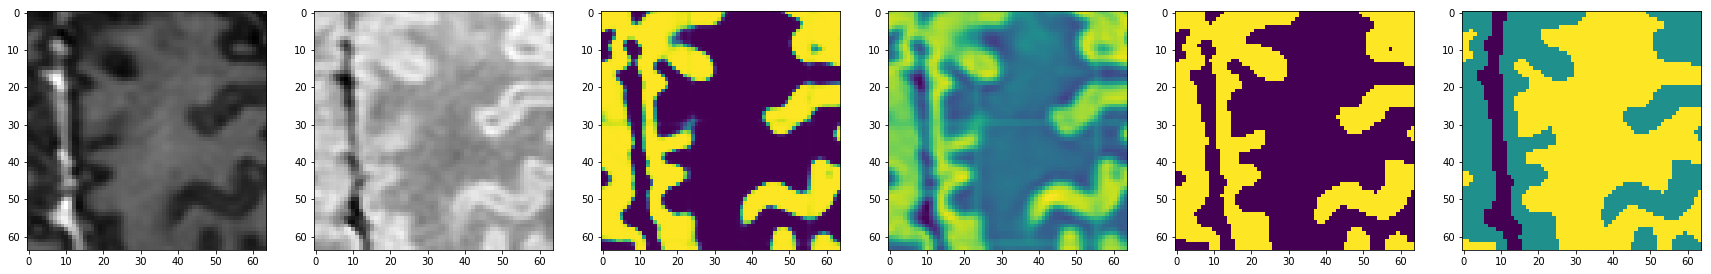

In [47]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 6, figsize=(30,30))
i = 1
axes[0].imshow(results[0][i][0,:,:,0], cmap='gray')
axes[1].imshow(results[0][i][0,:,:,1], cmap='gray')
axes[2].imshow(results[1][i][0,:,:,1])
axes[3].imshow(results[2][i][0,:,:,1])
axes[4].imshow(results[3][i][0])
axes[5].imshow(results[4][i][0])


In [ ]:
print()